In [1]:

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns



# Preprocesamiento
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder
import math
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer


#Linear Regresion con Sklearn
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics




# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Tamaño gráficas
# ==============================================================================
plt.rcParams["figure.figsize"] = (10,8)

Trabajamos para una compañia de seguros, nuestro jefe tiene unos datos sobre el dinero que gastan en una serie de clientes basándose en una serie de características, estas son:

1. **age**: Esta columna representa la edad de la persona a la que se refiere la entrada en el DataFrame. Por ejemplo, en la primera fila, la persona tiene 19 años.

2. **sex**: En esta columna, se indica el género o sexo de la persona. Puede tener dos posibles valores: "female" (femenino) o "male" (masculino). Por ejemplo, en la primera fila, la persona es de sexo femenino.

3. **bmi**: Esta columna se refiere al Índice de Masa Corporal (BMI, por sus siglas en inglés) de la persona. El BMI es una medida que relaciona el peso y la altura de una persona y se utiliza para evaluar su nivel de obesidad o peso saludable. Por ejemplo, en la primera fila, el BMI es 27.900.

4. **children**: Aquí se indica la cantidad de hijos o dependientes que tiene la persona. Puede ser un número entero. Por ejemplo, en la primera fila, la persona no tiene hijos (valor 0).

5. **smoker**: Esta columna indica si la persona es fumadora o no. Puede tener dos posibles valores: "yes" (sí) si es fumadora y "no" si no lo es. Por ejemplo, en la primera fila, la persona es fumadora.

6. **region**: En esta columna se especifica la región geográfica en la que reside la persona. Puede tomar varios valores que representan diferentes regiones geográficas. Por ejemplo, en la primera fila, la persona reside en la región "southwest" (suroeste).

7. **charges**: Esta columna se refiere a los cargos o costos médicos asociados a la persona. Los cargos médicos pueden incluir los gastos de atención médica y seguro de salud. Por ejemplo, en la primera fila, los cargos médicos son de 16884.92400.

Nuestro objetivo hacer un modelo de machine learning que nos permita predecir cuanto nos vamos a gastar en futuros clientes para decidir si les aceptamos como clientes o no. 


In [2]:
df = pd.read_csv("insurance.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,NaN,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,NaN,NaN,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


# Análisis exploratorio

In [3]:
# exploramos cuántas filas y columnas tenemos y los valores no nulos que tenemos por cada una de ellas
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1204 non-null   float64
 1   sex       1151 non-null   object 
 2   bmi       1325 non-null   float64
 3   children  1231 non-null   float64
 4   smoker    1057 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 83.6+ KB


In [4]:
# ¿tenemos nulos en el dataframe?
df.isnull().sum()

age         134
sex         187
bmi          13
children    107
smoker      281
region        1
charges       0
dtype: int64

In [5]:
# ¿tenemos duplicados en el dataframe?
df.duplicated().sum()

0

# Distribución variable respuesta

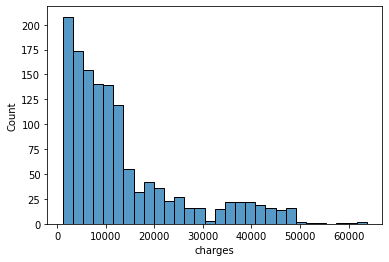

In [6]:
# lo primero que tenemos que ver es como se distribuye la variable respuesta

sns.histplot(data = df, x = "charges");

DEntro de los problemas de regresion lineal vamos a utilizar el algoritmo de regresión lineal, y una de las condiciones que tenemos que cumplir es que la VR respuesta sea normal,  por lo que lo primero que tenemos que hacer es evaluar si nuestra variable respuesta tiene una distribución normal. 
Recordamos que tenemos el test de shapiro, cuyos resultados pueden ser:


| Test Shapiro  |  Resultado | Conclusión |
|---|---|---|
|  p-value > 0.05 | No significativo   | Datos  Normales|
|p-value < 0.05| Significativo| Datos No Normales |

In [7]:
# nuestra VR no es normal, por lo que tendremos que intentar normalizarla.
stats.shapiro(df["charges"])

ShapiroResult(statistic=0.8146880269050598, pvalue=1.150477698013898e-36)

# Relación VR con VP numéricas

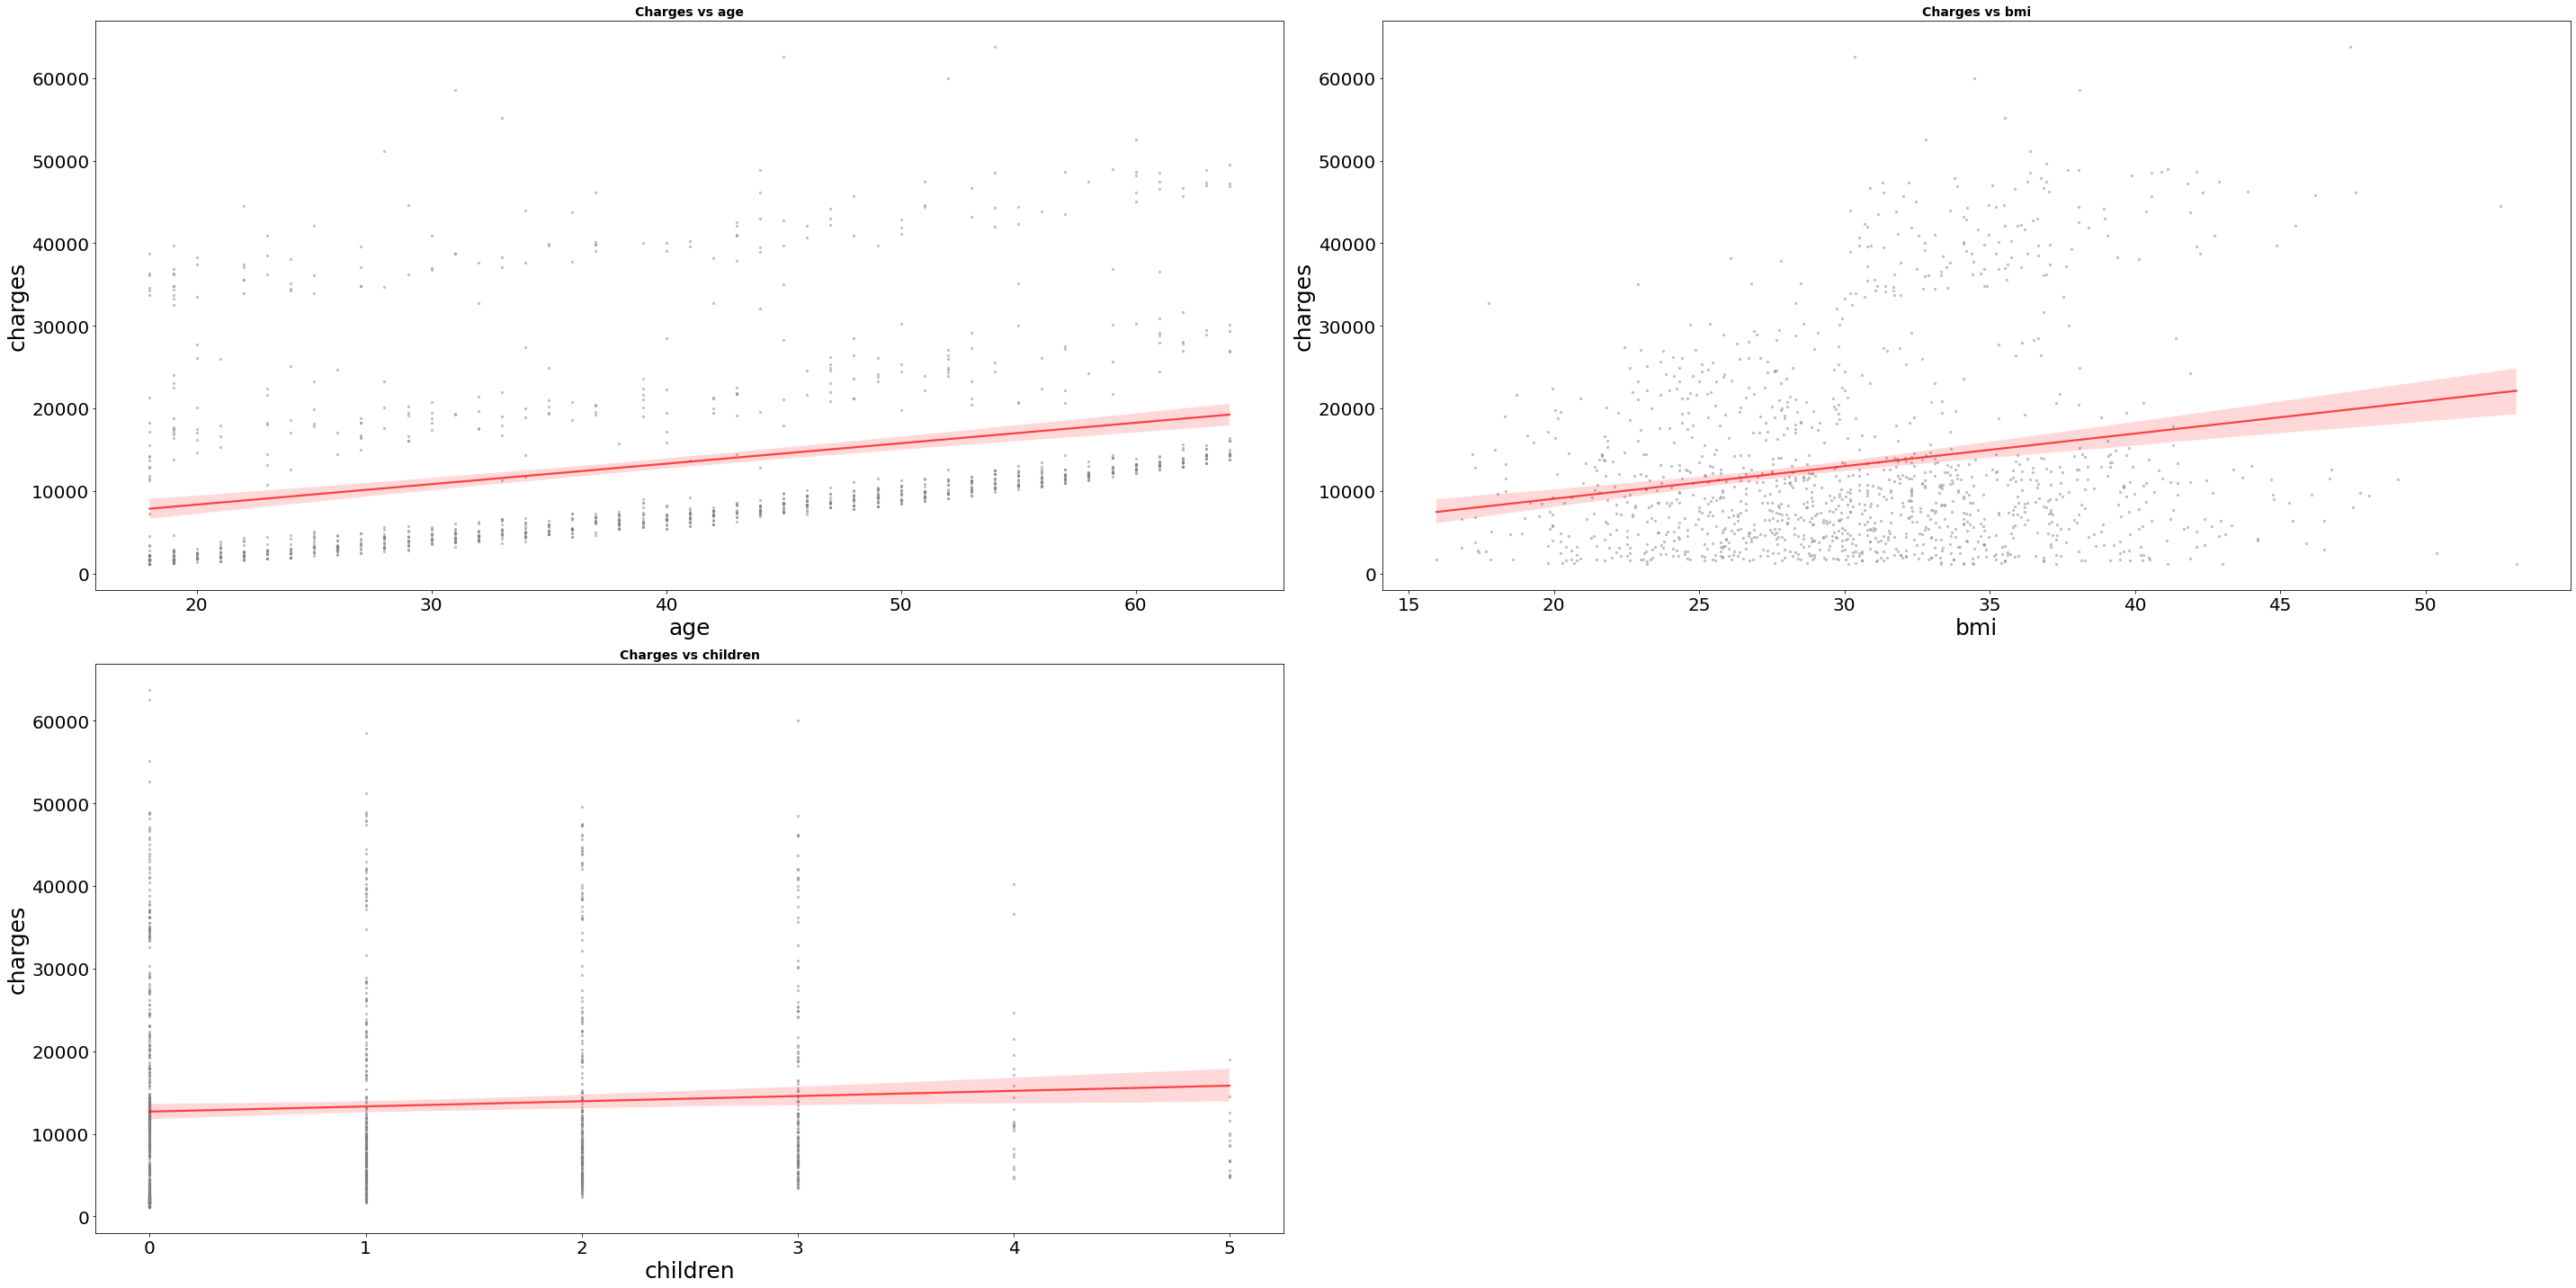

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4, "s":20 }, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum, fontsize = 25)
    axes[i].set_ylabel( "charges", fontsize = 25)
    
fig.tight_layout()
fig.delaxes(axes[-1]);

In [9]:
# antes de seguir ya estamos intuyendo que la variable "children" podríamos tratarla como categórica más que numérica, asi que cambiemos el tipo del dato

df["children"] = df["children"].astype('category')

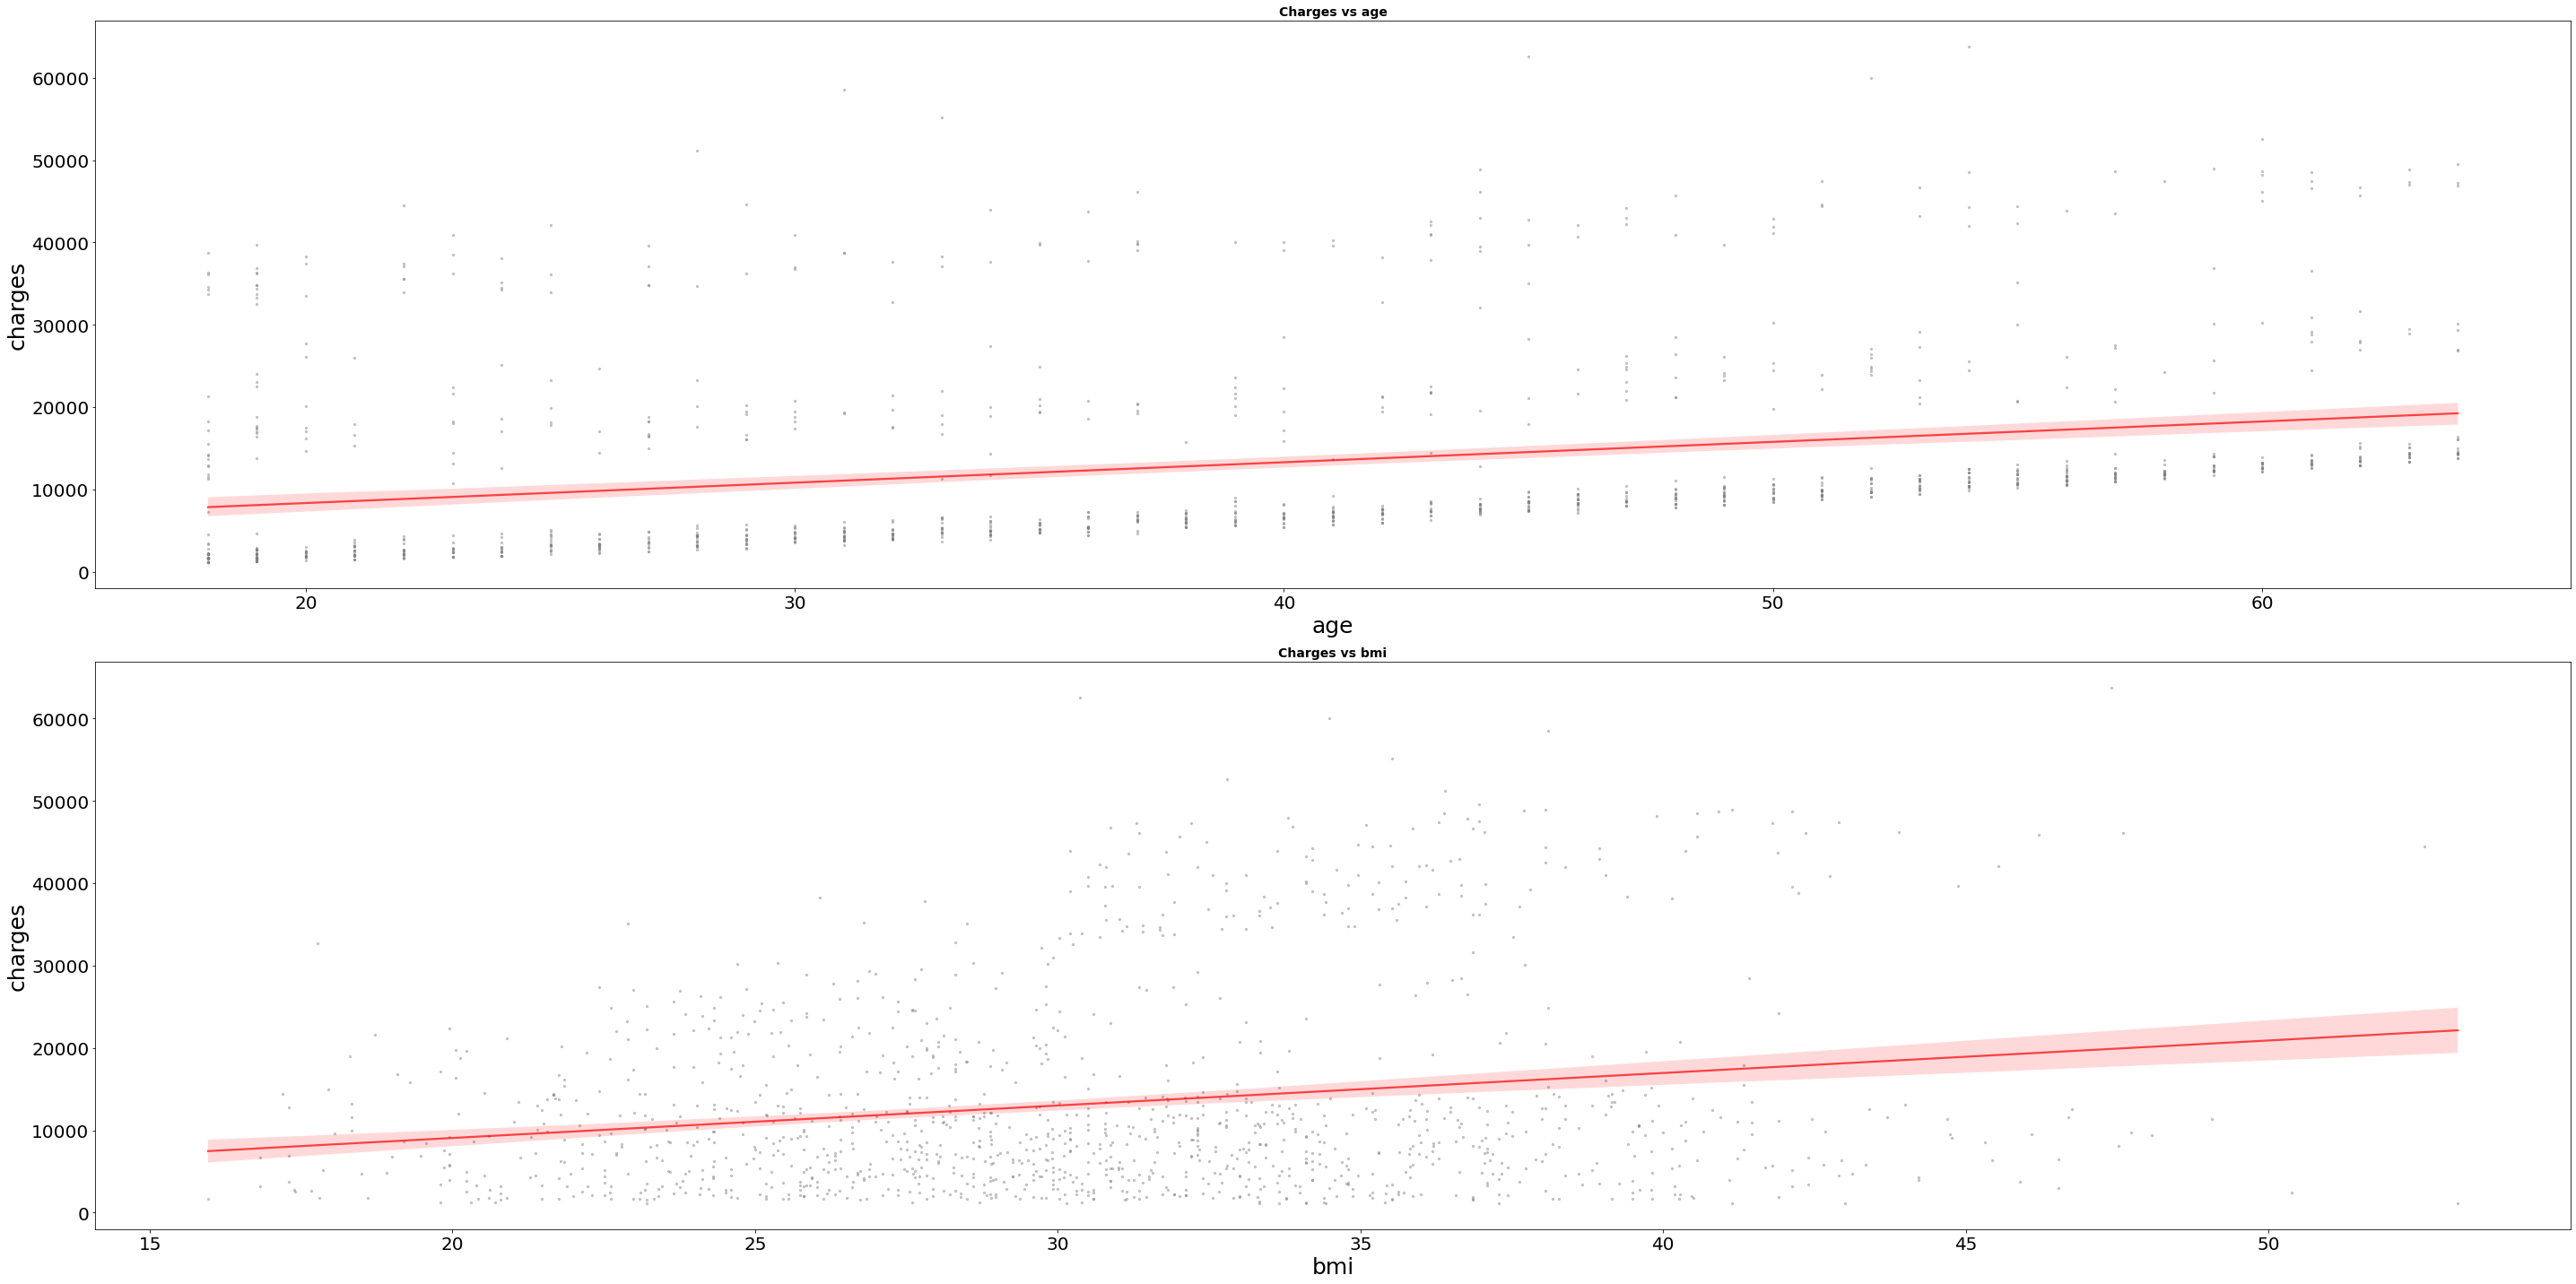

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (40, 20))

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4, "s":20 }, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum, fontsize = 25)
    axes[i].set_ylabel( "charges", fontsize = 25)
    
fig.tight_layout();

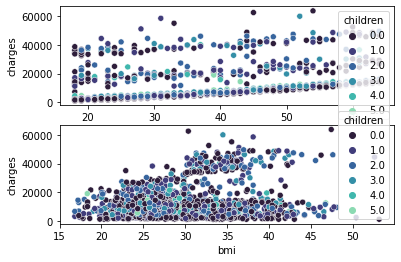

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 1)
sns.scatterplot(x = "age", y = "charges", hue = "children", data = df, palette="mako", ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "children", data = df, palette="mako", ax = axes[1]);

Aqui vemos como no existe nigun patron con el gasto de las aseguradoras


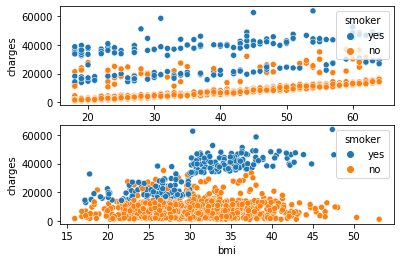

In [12]:
fig, axes = plt.subplots(nrows = 2, ncols = 1)
sns.scatterplot(x = "age", y = "charges", hue = "smoker", data = df, ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "smoker", data = df, ax = axes[1]);

vemos como los no fumadores pagran menos que los que si fuman 


# Variables predictoras categóricas

Nos ayudará a decidir si nuestras variables tienen orden o no. 

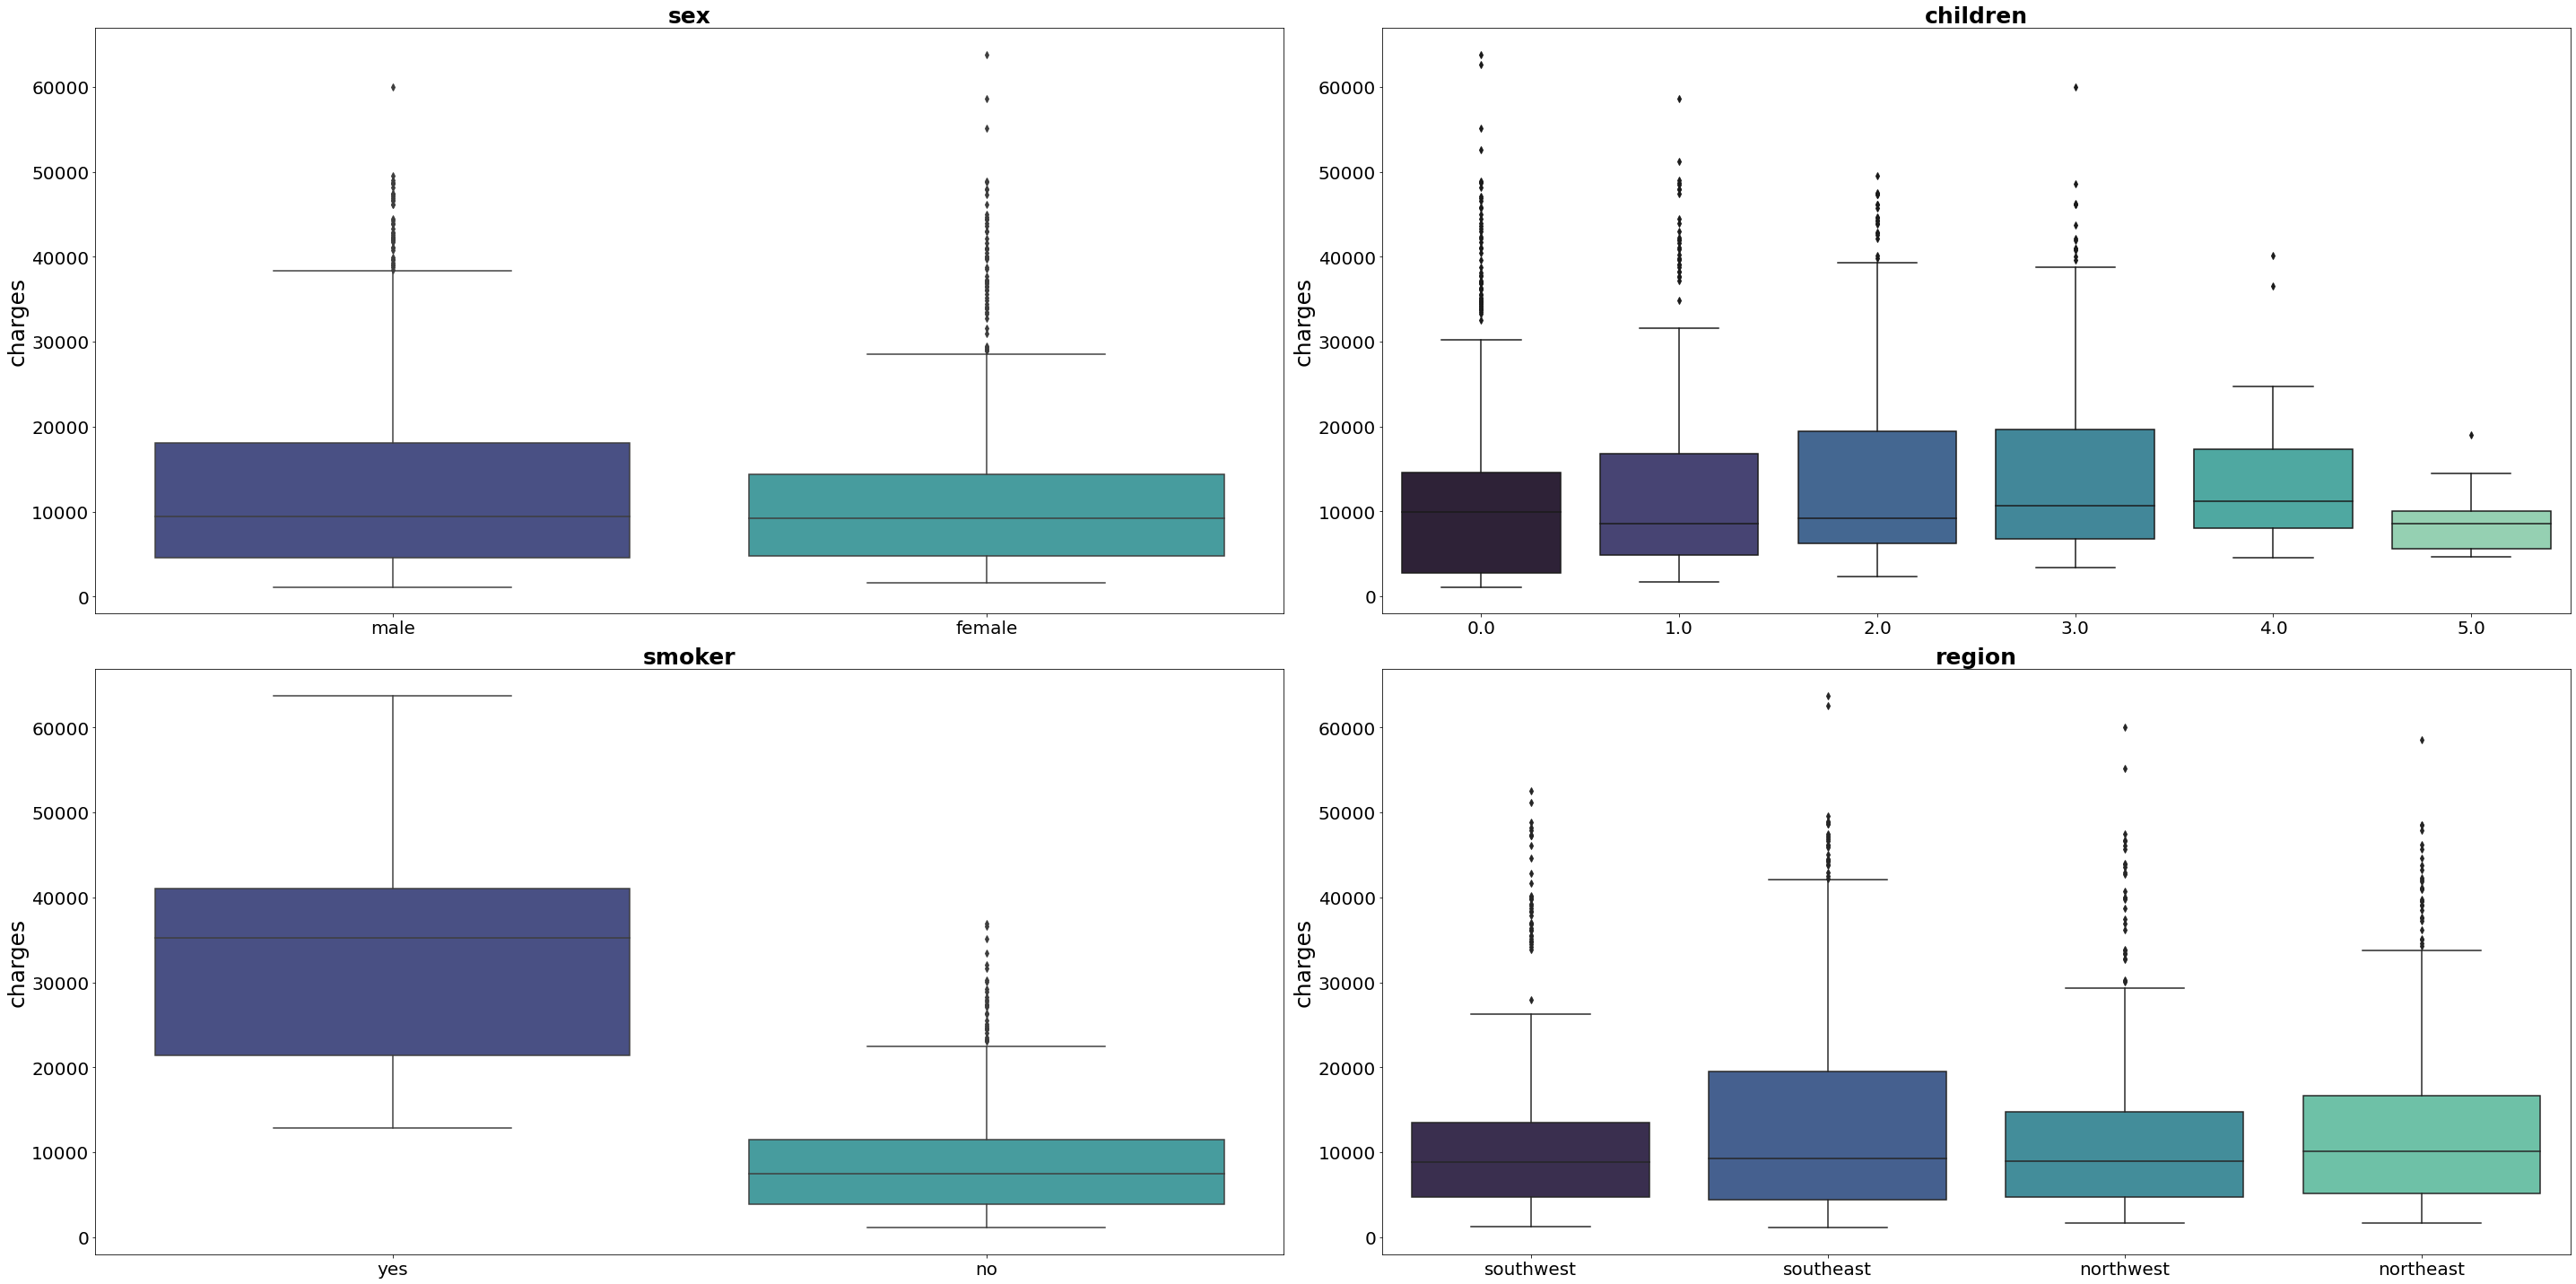

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_cat = df.select_dtypes(include = ["object", "category"]).columns

for i, colum in enumerate(columnas_cat): 
    sns.boxplot(
        data = df,
        x = colum,
        y = "charges",
        palette = "mako", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 25, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel( "charges", fontsize = 25)


fig.tight_layout();

# Outliers

In [14]:
# nos creamos un df con las numericas

numericas = df.select_dtypes(include = np.number)
numericas.head()

,age,bmi,charges
0,19.0,27.900,16884.92400
1,18.0,33.770,1725.55230
2,28.0,33.000,4449.46200
3,33.0,22.705,21984.47061
4,32.0,28.880,3866.85520


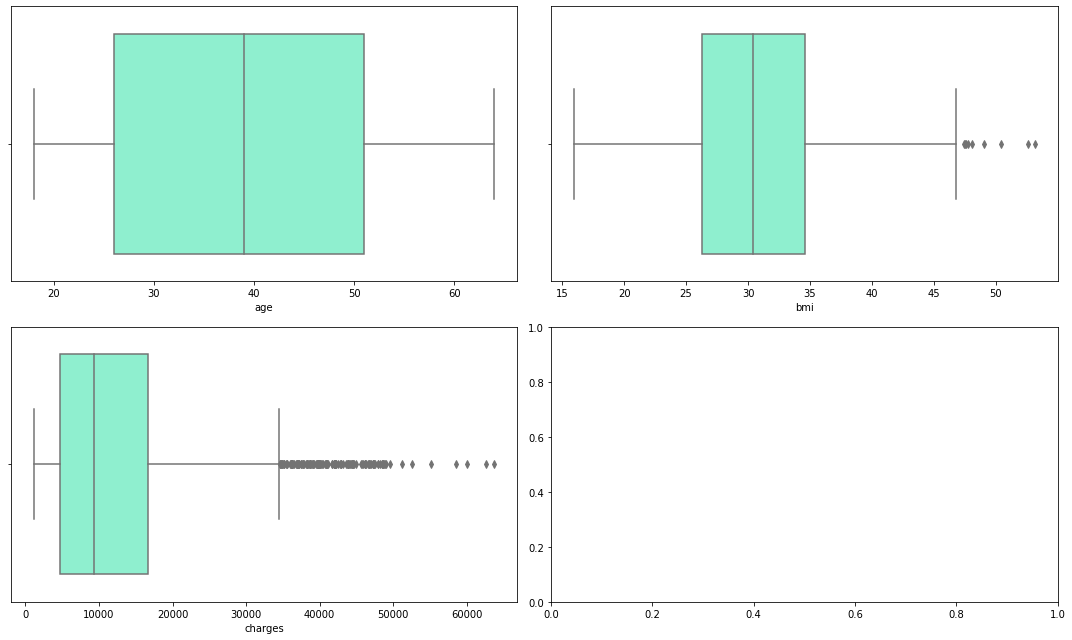

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15,9))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "aquamarine"); 

    
plt.tight_layout()
plt.show()

Llegados a este punto, vemos que tenemos muchos valores atípicos en la VR. En esta situación podríamos hacer dos cosas: 

- Seguir nuestro modelo con todos los datos

- Dividir el conjunto de datos en dos para hacer dos modelos: 

    - Un modelo para aquellos clientes por los que pagamos poco

    - Un modelo para aquellos clientes por los que pagamos mucho. 

    La pregunta en este punto es por donde dividiriamos los datos. Una buena elección es hacerlo por los cuartiles, en este caso por el cuartil 75 ya que los outliers los tenemos hacía los valores altos. 

In [16]:
# utilizamos el metodo de numpy np.nanpercentile para saber cual es el valor que corresponde al Q3
np.nanpercentile(df["charges"], 75)

16639.912515

In [17]:
# creamos un dataframe nuevo separando el conjunto de datos quitando los outliers
df_menores = df[df["charges"] < np.percentile(df["charges"], 75)]
df_menores.head(2)

,age,sex,bmi,children,smoker,region,charges
1,18.0,male,33.77,NaN,NaN,southeast,1725.5523
2,28.0,male,33.00,3.0,no,southeast,4449.4620


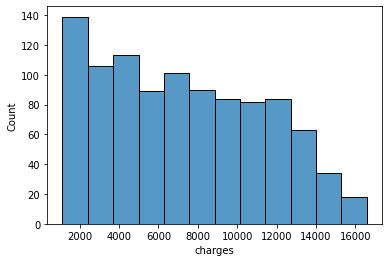

In [18]:
# veamos como es la distribucion ahora de la VR, a ver si ha cambiado algo
sns.histplot(data = df_menores, x = "charges");


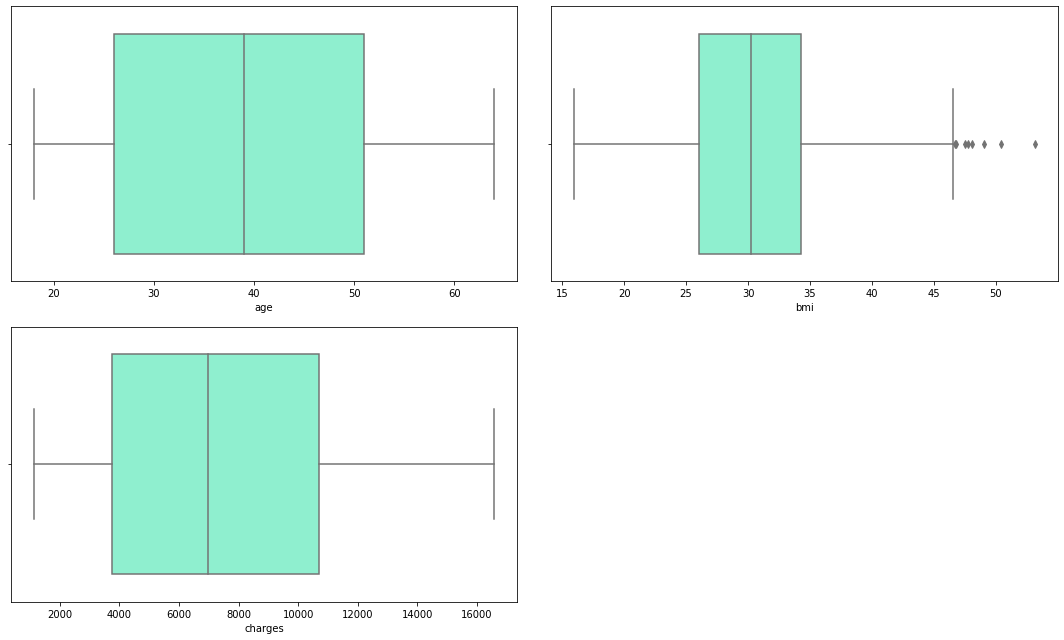

In [19]:


fig, axes = plt.subplots(2, 2, figsize=(15,9))

axes = axes.flat

for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = df_menores[columna], data = df_menores, ax=axes[indice], color = "aquamarine"); 

    
plt.tight_layout()
fig.delaxes(axes[-1]);

In [20]:
# hemos eliminado los outliers para la columna respuesta, pero todavía tenemos algunos para la columna bmi
# VAMOS A EXPLORARLOS
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 


lista_columnas = list(numericas.columns)
ind = detectar_outliers(lista_columnas, df_menores)
ind

{'bmi': [116, 286, 401, 847, 1088, 1317]}

Al ser pocos, podemos optar por no gestionar estos outliers, pero tenemos que tenerlo en cuenta de cara al futuro, a la hora de hacer la estandarización de las VP. Recordemos que en estos casos, es recomendable usar el RobustScaler. 

CUIDADO! HEMOS CAMBIADO EL CONJUNTO DE DATOS, POR LO QUE VAMOS A VOLVER A HACER LAS GRÁFICAS DE EXPLORACIÓN PARA VER SI HA CAMBIADO ALGO

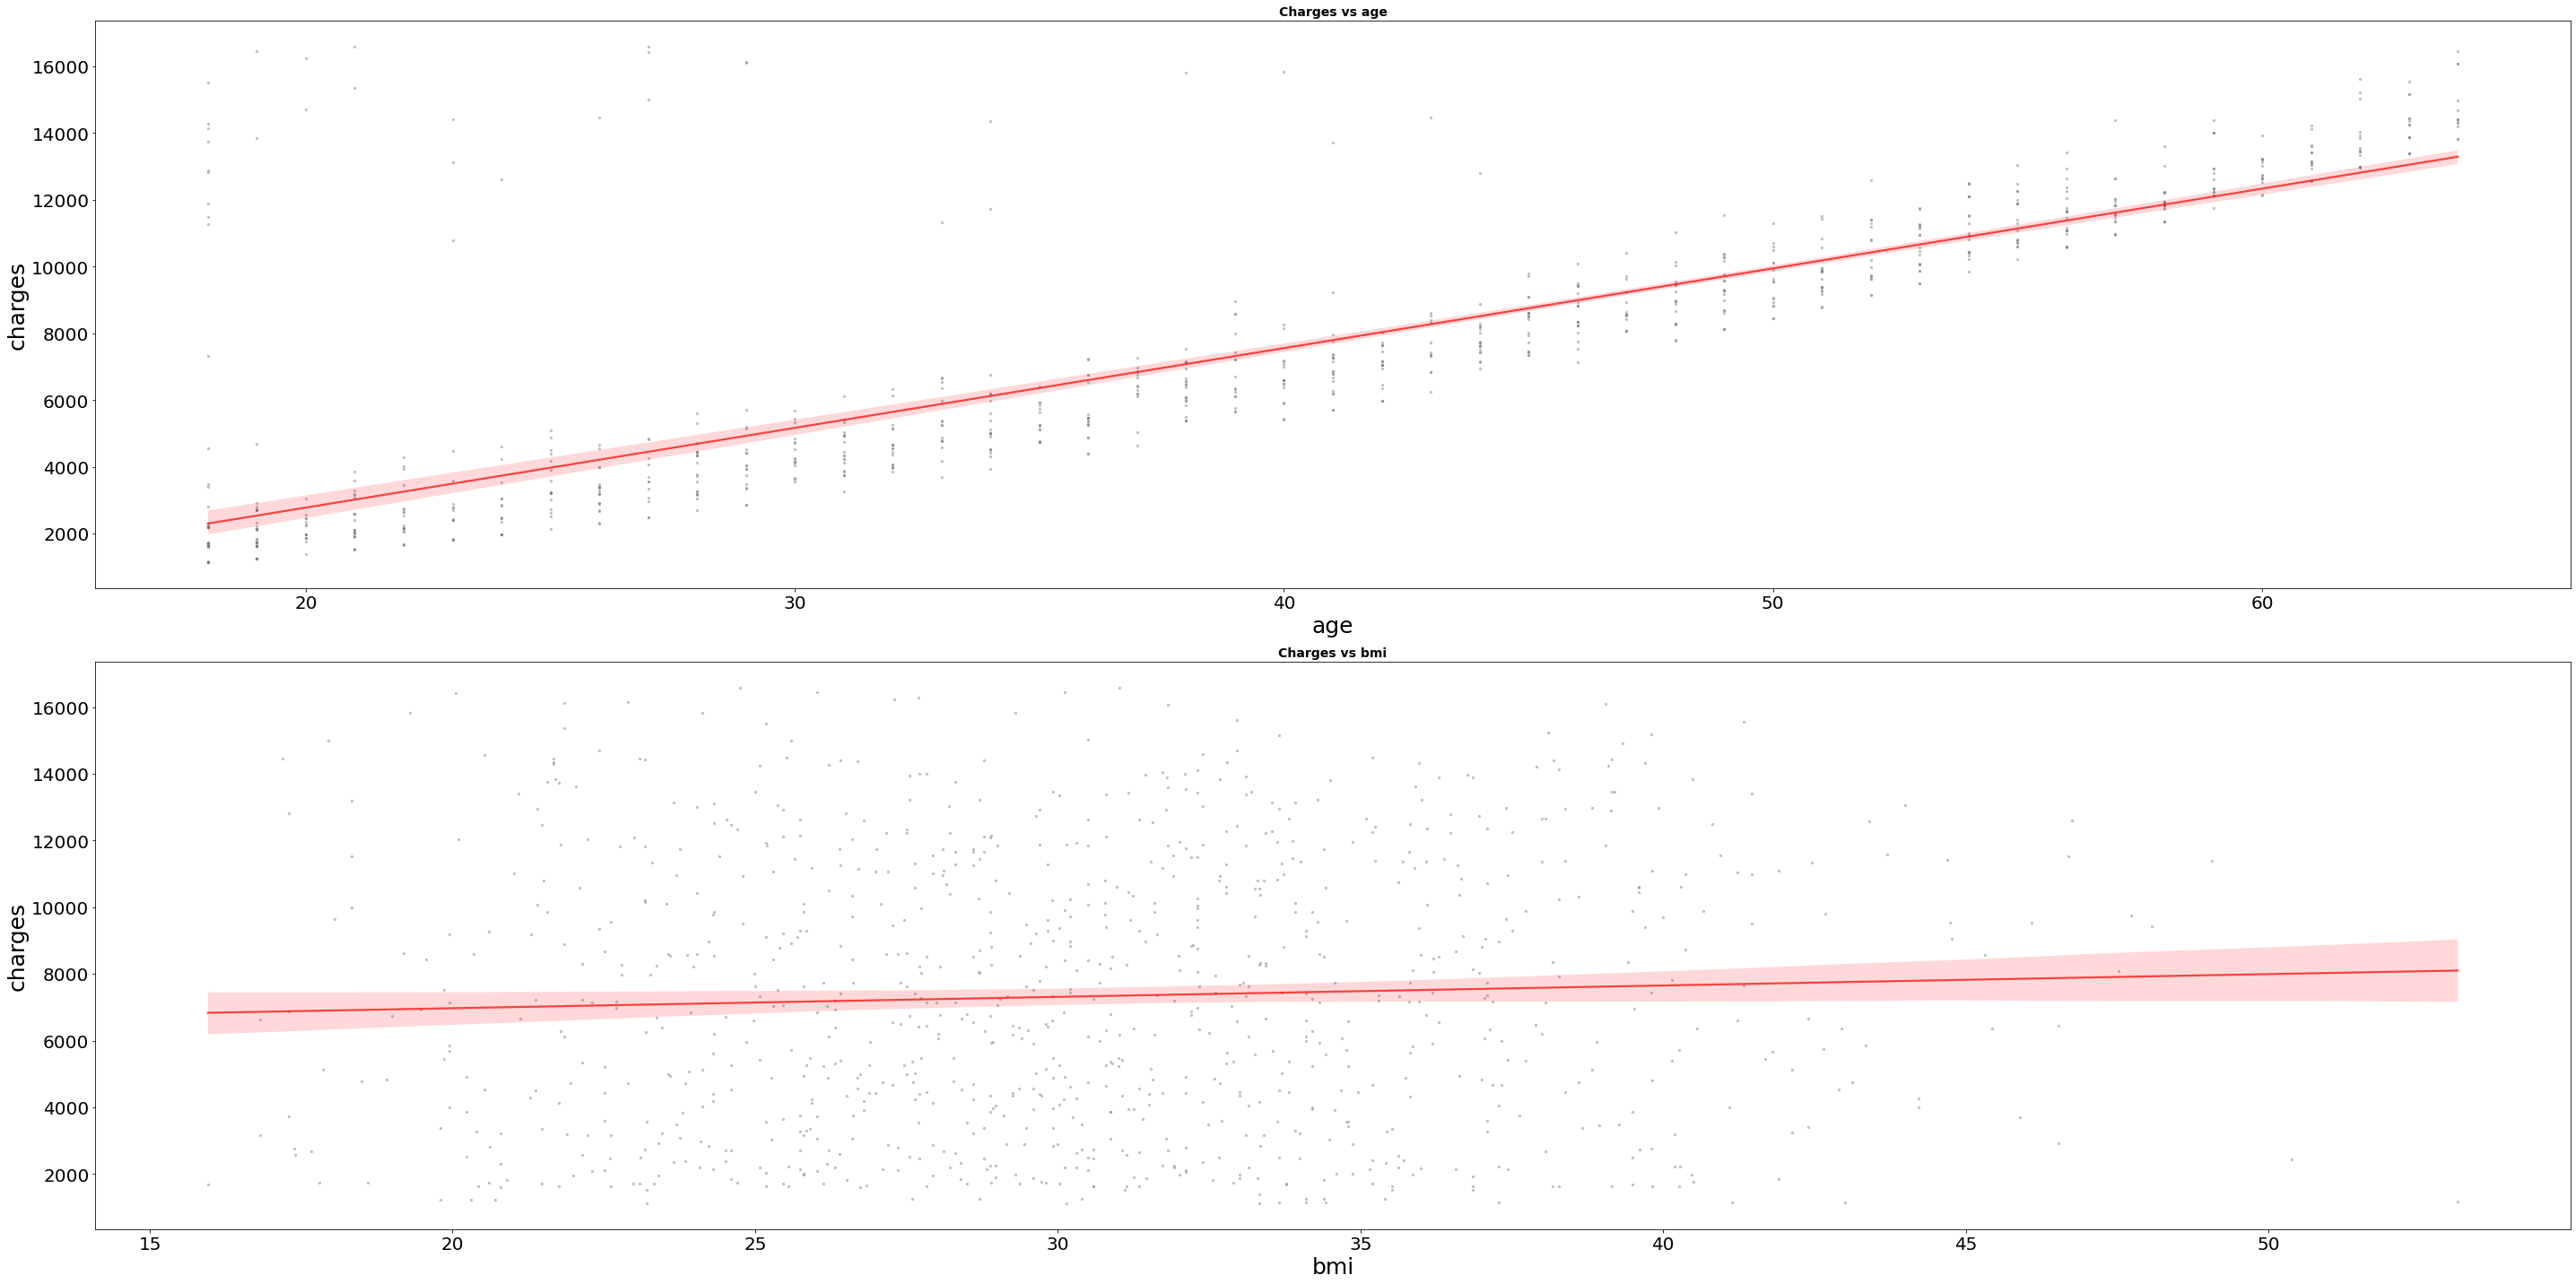

In [21]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (40, 20))

columnas_numeric = df_menores.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df_menores[colum], 
        y = df_menores["charges"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4, "s":20 }, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 14, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel(colum, fontsize = 25)
    axes[i].set_ylabel( "charges", fontsize = 25)
    
fig.tight_layout();

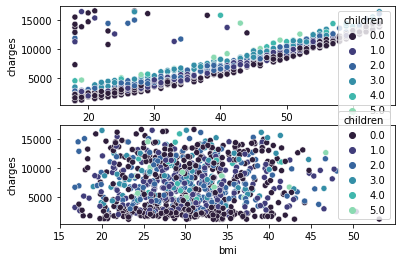

In [22]:
fig, axes = plt.subplots(nrows = 2, ncols = 1)
sns.scatterplot(x = "age", y = "charges", hue = "children", data = df_menores, palette="mako", ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "children", data = df_menores, palette="mako", ax = axes[1]);

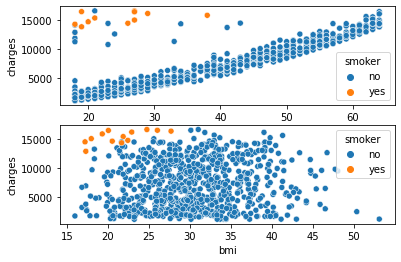

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols = 1)
sns.scatterplot(x = "age", y = "charges", hue = "smoker", data = df_menores, ax = axes[0])
sns.scatterplot(x = "bmi", y = "charges", hue = "smoker", data = df_menores, ax = axes[1]);

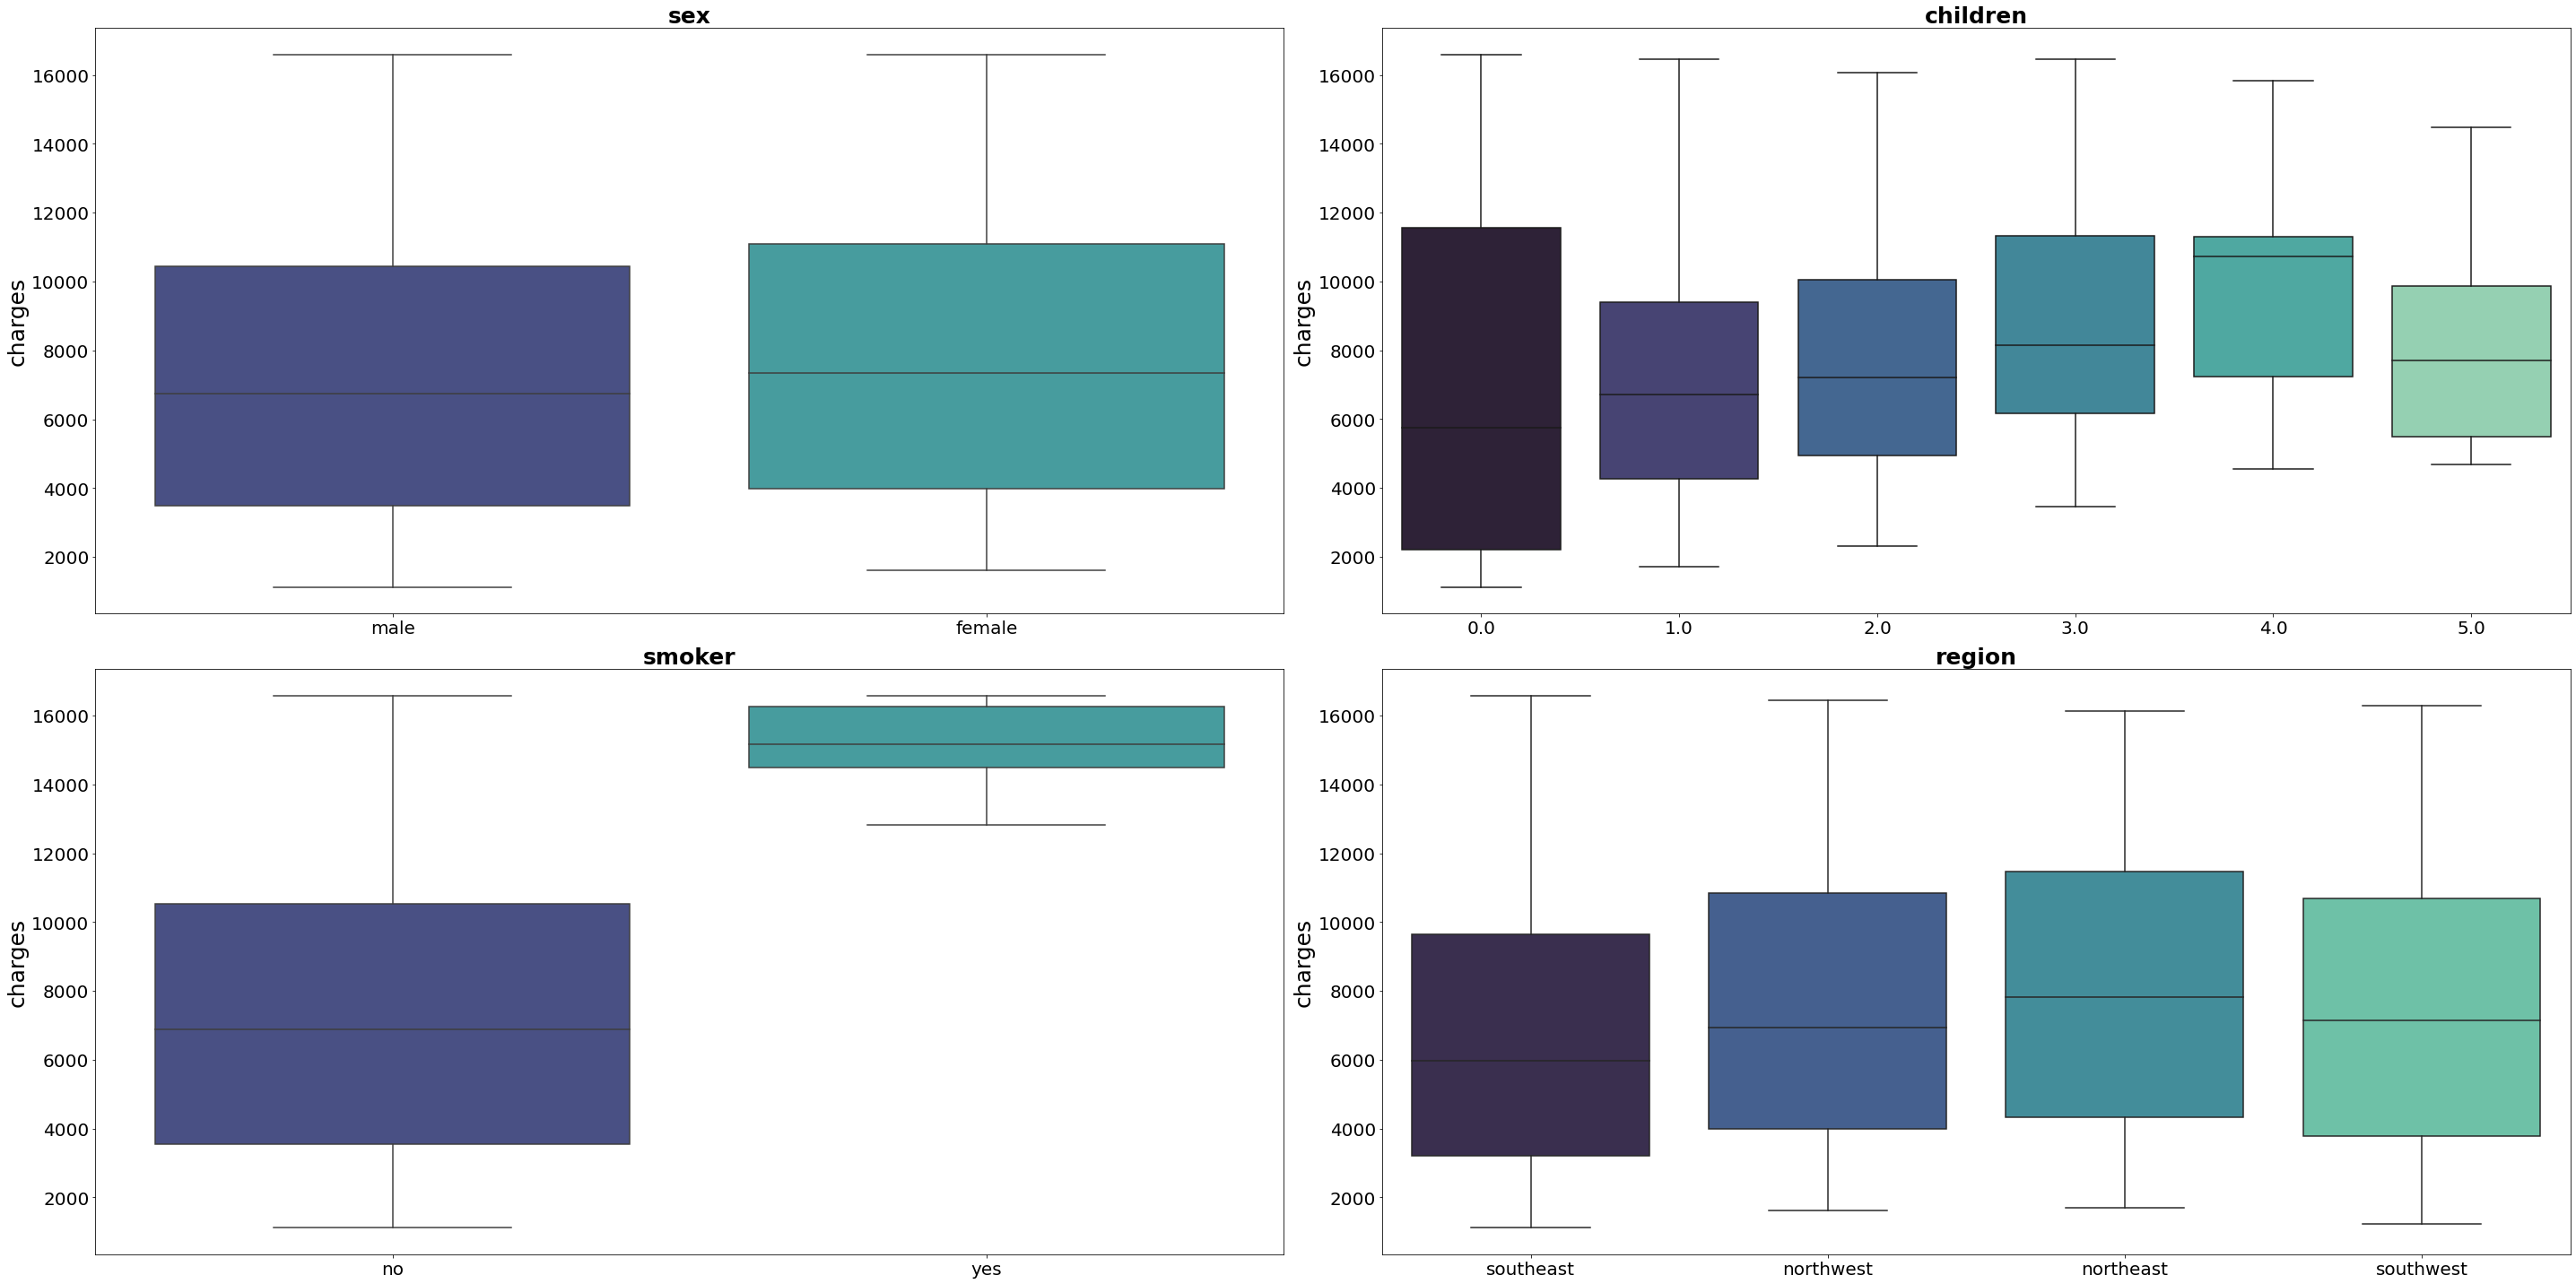

In [24]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_cat = df_menores.select_dtypes(include = ["object", "category"]).columns

for i, colum in enumerate(columnas_cat): 
    sns.boxplot(
        data = df_menores,
        x = colum,
        y = "charges",
        palette = "mako", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 25, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel( "charges", fontsize = 25)


fig.tight_layout();

# Gestión de nulos

## Categóricas

In [25]:
# Obtenemos la lista de columnas categóricas que tienen nulos
nulos_esta_cat = df_menores[df_menores.columns[df_menores.isnull().any()]].select_dtypes(include = ["O", "category"]).columns
print("Las columnas categóricas que tienen nulos son : \n ")
print(nulos_esta_cat)

Las columnas categóricas que tienen nulos son : 
 
Index(['sex', 'children', 'smoker', 'region'], dtype='object')


In [26]:
# sacamos el 'value_counts()'  de cada una de las columnas categóricas que tienen nulos para saber como es la distribución de sus categorías
for col in nulos_esta_cat:
    print(f"La distribución de las categorías para la columna {col.upper()}")
    display(df_menores[col].value_counts() / df_menores.shape[0])
    print("........................")

La distribución de las categorías para la columna SEX


sex
female    0.451645
male      0.419741
Name: count, dtype: float64

........................
La distribución de las categorías para la columna CHILDREN


children
0.0    0.405783
1.0    0.217348
2.0    0.160518
3.0    0.099701
4.0    0.016949
5.0    0.015952
Name: count, dtype: float64

........................
La distribución de las categorías para la columna SMOKER


smoker
no     0.783649
yes    0.013958
Name: count, dtype: float64

........................
La distribución de las categorías para la columna REGION


region
southwest    0.257228
southeast    0.250249
northwest    0.250249
northeast    0.241276
Name: count, dtype: float64

........................


In [27]:
columnas_moda = ["smoker", "children"]
columnas_nueva_categoria = ["sex", "region"]

In [28]:
# iteramos por la lista creada en el paso anterior:
for columna in columnas_moda:    
    # calculamos la moda para la columna por la que estamos iterando
    moda = df_menores[columna].mode()[0]    
    # utilizando el método fillna reemplazamos los valores nulos por la moda calculada en el paso anterior. 
    df_menores[columna] = df_menores[columna].fillna(moda)

# por último chequeamos si se han eliminado los nulos en las columnas de "marital" y "loan"
print("Después del reemplazo usando 'fillna' quedan los siguientes nulos")

df_menores[columnas_moda].isnull().sum()

Después del reemplazo usando 'fillna' quedan los siguientes nulos


smoker      0
children    0
dtype: int64

In [29]:
# iteramos por la lista creada en el paso anterior:
for columna in columnas_nueva_categoria:  
    
    # utilizando el método fillna reemplazamos los valores nulos por la moda calculada en el paso anterior. 
    df_menores[columna] = df_menores[columna].fillna("Unknown")

# por último chequeamos si se han eliminado los nulos en las columnas de "marital" y "loan"
print("Después del reemplazo usando 'fillna' quedan los siguientes nulos")

df_menores[columnas_nueva_categoria].isnull().sum()

Después del reemplazo usando 'fillna' quedan los siguientes nulos


sex       0
region    0
dtype: int64

## Numéricas

In [30]:
# Obtenemos la lista de columnas categóricas que tienen nulos
nulos_esta_num = df_menores[df_menores.columns[df_menores.isnull().any()]].select_dtypes(include = np.number).columns
print("Las columnas numéricas que tienen nulos son : \n ")
print(nulos_esta_num)

Las columnas numéricas que tienen nulos son : 
 
Index(['age', 'bmi'], dtype='object')


In [31]:
# lo primero que vamos a hacer es calcular el número de nulos que tenemos en cada una de las columnas numericas
df_menores[nulos_esta_num].isnull().sum() / df_menores.shape[0]

age    0.094716
bmi    0.007976
dtype: float64

In [32]:
# simplemente para recordar distintos metodos usaremos el fillna para el bmi
df_menores.describe().T[["mean", "50%"]]

,mean,50%
age,38.938326,39.000
bmi,30.436884,30.200
charges,7312.558345,6986.697


In [33]:
df_menores["bmi"] = df_menores["bmi"].fillna(df_menores["bmi"].median())

In [34]:
# para el caso de la columna "age" utilizaremos los dos metodos avanzados y compararemos

# hemos dicho que para las tres columnas restantes aplicaremos los dos métodos para luego compararlos, empezaremos por el IterativeImputer
# instanciamos las clases
imputer_iterative = IterativeImputer(max_iter = 20, random_state = 42)

# ajustamos y tranformamos los datos
imputer_iterative_imputado = imputer_iterative.fit_transform(df_menores[["age"]])

df_menores[["age_imputer"]] = imputer_iterative_imputado


In [35]:
# hagamos ahora lo mismo con el KNNImputer

# instanciamos la clase del KNNImputer
imputer_knn = KNNImputer(n_neighbors = 5)

# ajustamos y transformamos los datos
imputer_knn_imputado = np.round(imputer_knn.fit_transform(df_menores[["age"]]), 2)

df_menores[["age_knn"]] = imputer_knn_imputado


In [36]:
# comprobamos que método ha ajustado mejor
df_menores.describe().loc[["mean", "50%"], ["age", "age_imputer", "age_knn"]]

,age,age_imputer,age_knn
mean,38.938326,38.938326,38.938485
50%,39.000000,38.938326,38.940000


In [37]:
# nos quedamos con imputer
df_menores.drop(["age", "age_knn"], axis = 1, inplace=True)
df_menores.head()

,sex,bmi,children,smoker,region,charges,age_imputer
1,male,33.77,0.0,no,southeast,1725.5523,18.0
2,male,33.00,3.0,no,southeast,4449.4620,28.0
4,male,28.88,0.0,no,northwest,3866.8552,32.0
5,female,25.74,0.0,no,southeast,3756.6216,31.0
6,female,33.44,1.0,no,southeast,8240.5896,46.0


# Estandarizacion 

La columna de bmi tenía valores atípicos, por lo el mejor método es Robust Scaler

In [38]:
robust = RobustScaler()
bmi_tranformadas = pd.DataFrame(robust.fit_transform(df_menores[["bmi"]]))
df_menores["bmi"] = bmi_tranformadas
df_menores.head()

,sex,bmi,children,smoker,region,charges,age_imputer
1,male,0.342298,0.0,no,southeast,1725.5523,18.0
2,male,-0.161369,3.0,no,southeast,4449.4620,28.0
4,male,0.396088,0.0,no,northwest,3866.8552,32.0
5,female,-0.300733,0.0,no,southeast,3756.6216,31.0
6,female,-0.045232,1.0,no,southeast,8240.5896,46.0


In [39]:
# nos queda la columna de "age_imputer"
st = StandardScaler()
x_tranformadas = pd.DataFrame(st.fit_transform(df_menores[["age_imputer"]]))
df_menores["age_imputer"] = x_tranformadas
df_menores.head()

,sex,bmi,children,smoker,region,charges,age_imputer
1,male,0.342298,0.0,no,southeast,1725.5523,-0.814847
2,male,-0.161369,3.0,no,southeast,4449.4620,-0.516868
4,male,0.396088,0.0,no,northwest,3866.8552,0.526057
5,female,-0.300733,0.0,no,southeast,3756.6216,-0.144395
6,female,-0.045232,1.0,no,southeast,8240.5896,-0.144395


# Normalización

In [40]:
df_menores["charges_box"], lambda_ajustada = stats.boxcox(df_menores['charges'])
df_menores['charges_log'] = df_menores['charges'].apply(lambda x: np.log(x) if x != 0 else 0)
df_menores['charges_SQRT'] = df_menores['charges'].apply(lambda x: math.sqrt(x))

# construir el modelo de escalador
minmax = MinMaxScaler()
df_menores["charges_Minmax"] = minmax.fit_transform(df_menores[["charges"]])
df_menores.head(2)

,sex,bmi,children,smoker,region,charges,age_imputer,charges_box,charges_log,charges_SQRT,charges_Minmax
1,male,0.342298,0.0,no,southeast,1725.5523,-0.814847,83.992451,7.453302,41.539768,0.039036
2,male,-0.161369,3.0,no,southeast,4449.4620,-0.516868,136.891159,8.400538,66.704288,0.215174


In [41]:
for i in df_menores.columns[-4:]:
   print(f"La transformación {i} tiene un valor de shapiro de: {stats.shapiro(df_menores[i])[1]}")

La transformación charges_box tiene un valor de shapiro de: 2.710290708361632e-15
La transformación charges_log tiene un valor de shapiro de: 3.7685030388814684e-20
La transformación charges_SQRT tiene un valor de shapiro de: 2.5871880220053756e-15
La transformación charges_Minmax tiene un valor de shapiro de: 4.892670421982957e-17


In [42]:
# ninguno cumple la asunciones, por lo que nos quedamos con la variable original
df_menores.drop(df_menores.columns[-4:], axis = 1, inplace = True)
df_menores.head()

,sex,bmi,children,smoker,region,charges,age_imputer
1,male,0.342298,0.0,no,southeast,1725.5523,-0.814847
2,male,-0.161369,3.0,no,southeast,4449.4620,-0.516868
4,male,0.396088,0.0,no,northwest,3866.8552,0.526057
5,female,-0.300733,0.0,no,southeast,3756.6216,-0.144395
6,female,-0.045232,1.0,no,southeast,8240.5896,-0.144395


# Encoding

- variables con orden:  smoker, children

- variables sin orden: sex, region

In [43]:
# vamos a definir una función que nos aplique este método

def one_hot_encoder(dff, columnas):
        
    oh = OneHotEncoder()
    
    transformados = oh.fit_transform(dff[columnas])
    
    oh_df = pd.DataFrame(transformados.toarray(), columns = oh.get_feature_names_out(), dtype = int)
    
    dff[oh_df.columns] = oh_df
    
    dff.drop(columnas, axis = 1, inplace = True)
    
    return dff

columnas_sin_orden = ["sex", "region"]
df_menores = one_hot_encoder(df_menores, columnas_sin_orden)
df_menores.head()

,bmi,children,smoker,charges,age_imputer,sex_Unknown,sex_female,sex_male,region_Unknown,region_northeast,region_northwest,region_southeast,region_southwest
1,0.342298,0.0,no,1725.5523,-0.814847,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.161369,3.0,no,4449.4620,-0.516868,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.396088,0.0,no,3866.8552,0.526057,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-0.300733,0.0,no,3756.6216,-0.144395,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,-0.045232,1.0,no,8240.5896,-0.144395,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [44]:

orden_smoker = {"no": 0, "yes": 1}
df_menores["smoker"] = df_menores["smoker"].map(orden_smoker)

In [45]:
orden_children = {0.0: 0, 1.0: 0, 2.0: 0 , 3.0: 1, 4.0:2, 5.0:1 }
df_menores["children"] = df_menores["children"].map(orden_children)

In [46]:
df_menores.head()

,bmi,children,smoker,charges,age_imputer,sex_Unknown,sex_female,sex_male,region_Unknown,region_northeast,region_northwest,region_southeast,region_southwest
1,0.342298,0,0,1725.5523,-0.814847,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.161369,1,0,4449.4620,-0.516868,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.396088,0,0,3866.8552,0.526057,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-0.300733,0,0,3756.6216,-0.144395,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,-0.045232,0,0,8240.5896,-0.144395,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
df_menores
# guardar el dataframe
df_menores.to_csv("df_menores.csv")